In [1]:
!unzip data_input41.zip

unzip:  cannot find or open data_input41.zip, data_input41.zip.zip or data_input41.zip.ZIP.


In [ ]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 12.4 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import keras
from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda
from keras.layers import Convolution2D
from keras.layers.pooling import MaxPooling2D
from keras.layers import Cropping2D
from keras.layers.core import Dense, Dropout, Activation
from keras.layers import Dense, Conv1D, Flatten, MaxPooling1D
from keras import regularizers
from keras.layers import BatchNormalization
from keras.utils import np_utils
from keras.utils import plot_model
import graphviz, pydot, pydotplus
from sklearn.model_selection import train_test_split
import tensorflow as tf

In [ ]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0,1"

In [ ]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [ ]:
root_folder = "data_input41/01_healthy"
healthy = []
for root, dirs, files in os.walk(root_folder):  
    for filename in files:
        healthy.append(filename)

In [ ]:
measurements = []
classifications = []
count_healhy = 0
for sample in healthy:
    df = pd.read_csv(os.path.join(root_folder,sample), sep='\t',skiprows=[0],
        header=None, names=[ 'Wave', 'Intensity'])
    measurements.append(df[['Intensity']].to_numpy())
    classifications.append([1,0])
    count_healhy += 1

print(f'Здоровые ткани: {count_healhy}')

Здоровые ткани: 432


In [ ]:
sick_path = 'data_input41/image_tumor_patient20022019_633nm.txt'
count_sick = 0
df = pd.read_csv(sick_path, sep='\t',skiprows=[0],
    header=None, names=['X', 'Y', 'Wave', 'Intensity'])
for i in range(456):
    measurements.append(df[['Intensity']][i*len(df['Wave'].unique()):(i+1)*len(df['Wave'].unique())].to_numpy())
    classifications.append([0,1])
    count_sick += 1

print(f'Больные ткани: {count_sick}')
print(f'Всего образцов: {count_healhy + count_sick}')

Больные ткани: 456
Всего образцов: 888


In [ ]:
X = np.asarray(measurements)
y = np.asarray(classifications)

In [ ]:
X.shape

(888, 1015, 1)

In [ ]:
X = X.reshape(888, 1015)
X.shape

(888, 1015)

In [ ]:
y.shape

(888, 2)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.24, random_state=42)
print(f'Total amount of train measurements: {X_train.shape}')
print(f'Total amount of train labels: {y_train.shape}')
print(f'Total amount of test measurements: {X_test.shape}')
print(f'Total amount of test labels: {y_test.shape}')
y_train_labels = np.argmax(y_train, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

Total amount of train measurements: (674, 1015)
Total amount of train labels: (674, 2)
Total amount of test measurements: (214, 1015)
Total amount of test labels: (214, 2)


Precision - доля объектов, названных классификатором положительными и при этом действительно являющимися положительными

Recall показывает, какую долю объектов положительного класса из всех объектов положительного класса нашел алгоритм.

F1 - среднее гармоническое precision и recall

In [ ]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:
# Model 1
model = Sequential()
model.add(Conv1D(128, 4, activation='relu', input_shape=(1015,1),kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4))) # 32 neurons
model.add(Conv1D(128, 4, activation='relu', bias_regularizer=regularizers.l2(1e-4))) # 32 neurons
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling1D())
model.add(Dropout(0.25))
model.add(Conv1D(256, 2, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4))) # 64 neurons
model.add(Conv1D(256, 2, activation='relu', bias_regularizer=regularizers.l2(1e-4))) # 64 neurons
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling1D())
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(256, activation = 'relu', use_bias=False))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(128, activation = 'relu', use_bias=False))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(64, activation = 'relu', use_bias=False))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(Dense(2, activation = 'softmax'))
model.summary()
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', f1])
model_hist = model.fit(X_train, y_train, batch_size=64, epochs=40, verbose=1)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 1012, 128)         640       
                                                                 
 conv1d_1 (Conv1D)           (None, 1009, 128)         65664     
                                                                 
 batch_normalization (BatchN  (None, 1009, 128)        512       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 1009, 128)         0         
                                                                 
 max_pooling1d (MaxPooling1D  (None, 504, 128)         0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 504, 128)          0

In [ ]:
acc = model.evaluate(X_test, y_test)
print("Loss:", acc[0], " Accuracy:", acc[1], " F1 :", acc[2])
pred = model.predict(X_test)
print(np.round(pred,2)[0], np.round(pred,2)[1])
#model.save("model1.h5")

7/7 [==============================] - 0s 13ms/step - loss: 0.7416 - accuracy: 0.5467 - f1: 0.5386
Loss: 0.7415792942047119  Accuracy: 0.5467289686203003  F1 : 0.5385551452636719
7/7 [==============================] - 0s 10ms/step
[0.5 0.5] [0.54 0.46]


In [ ]:
np.round(pred,2)

array([[0.5 , 0.5 ],
       [0.54, 0.46],
       [0.58, 0.42],
       [0.53, 0.47],
       [0.74, 0.26],
       [0.52, 0.48],
       [0.55, 0.45],
       [0.47, 0.53],
       [0.55, 0.45],
       [0.47, 0.53],
       [0.6 , 0.4 ],
       [0.58, 0.42],
       [0.81, 0.19],
       [0.56, 0.44],
       [0.55, 0.45],
       [0.59, 0.41],
       [0.53, 0.47],
       [0.59, 0.41],
       [0.59, 0.41],
       [0.53, 0.47],
       [0.81, 0.19],
       [0.56, 0.44],
       [0.71, 0.29],
       [0.98, 0.02],
       [0.47, 0.53],
       [0.58, 0.42],
       [0.55, 0.45],
       [0.49, 0.51],
       [0.55, 0.45],
       [0.59, 0.41],
       [0.64, 0.36],
       [0.65, 0.35],
       [0.49, 0.51],
       [0.78, 0.22],
       [0.45, 0.55],
       [0.55, 0.45],
       [0.47, 0.53],
       [0.78, 0.22],
       [0.47, 0.53],
       [0.75, 0.25],
       [0.67, 0.33],
       [0.53, 0.47],
       [0.77, 0.23],
       [0.8 , 0.2 ],
       [0.48, 0.52],
       [0.54, 0.46],
       [0.77, 0.23],
       [0.66,

7/7 [==============================] - 0s 12ms/step
TrueLabel: Sick, PredLabel Health; PredProb: [0.52 0.48], TrueProb [0 1]


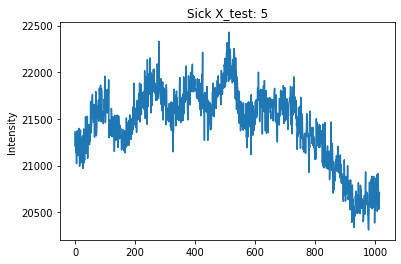

TrueLabel: Health, PredLabel Health; PredProb: [0.55 0.45], TrueProb [1 0]


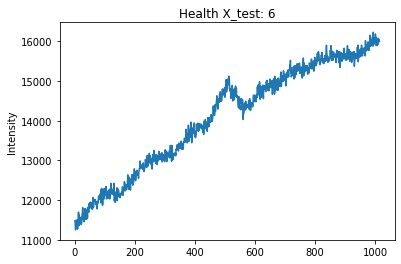

TrueLabel: Sick, PredLabel Sick; PredProb: [0.47 0.53], TrueProb [0 1]


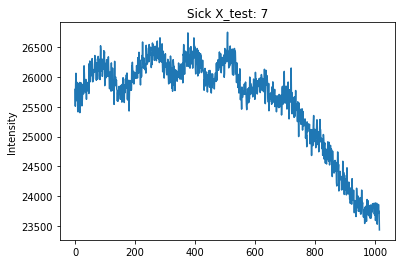

TrueLabel: Sick, PredLabel Health; PredProb: [0.55 0.45], TrueProb [0 1]


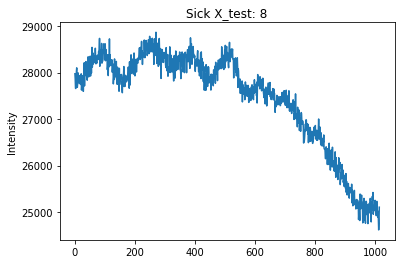

TrueLabel: Sick, PredLabel Sick; PredProb: [0.47 0.53], TrueProb [0 1]


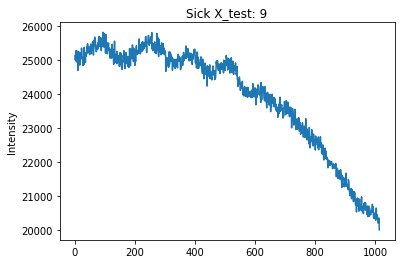

TrueLabel: Sick, PredLabel Health; PredProb: [0.6 0.4], TrueProb [0 1]


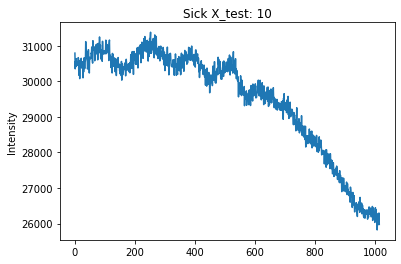

TrueLabel: Health, PredLabel Health; PredProb: [0.58 0.42], TrueProb [1 0]


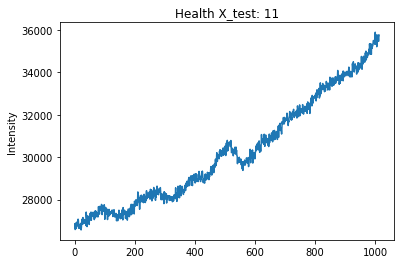

TrueLabel: Sick, PredLabel Health; PredProb: [0.81 0.19], TrueProb [0 1]


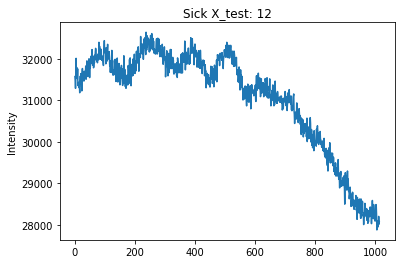

TrueLabel: Health, PredLabel Health; PredProb: [0.56 0.44], TrueProb [1 0]


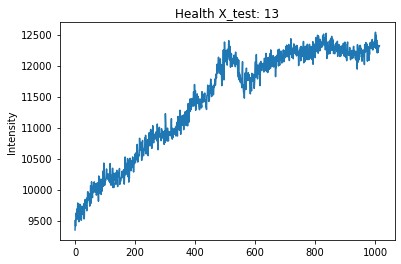

TrueLabel: Sick, PredLabel Health; PredProb: [0.55 0.45], TrueProb [0 1]


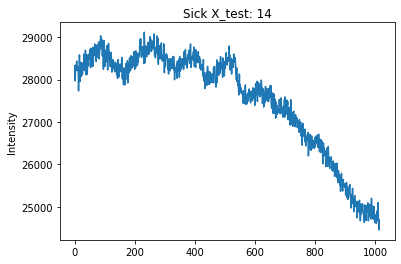

TrueLabel: Sick, PredLabel Health; PredProb: [0.59 0.41], TrueProb [0 1]


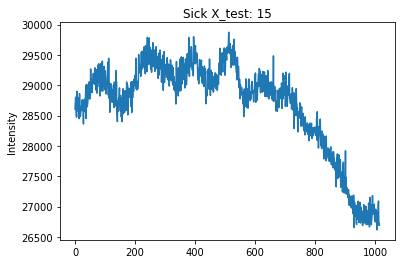

TrueLabel: Sick, PredLabel Health; PredProb: [0.53 0.47], TrueProb [0 1]


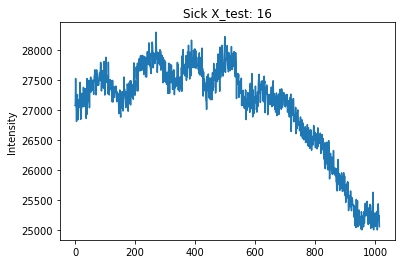

TrueLabel: Sick, PredLabel Health; PredProb: [0.59 0.41], TrueProb [0 1]


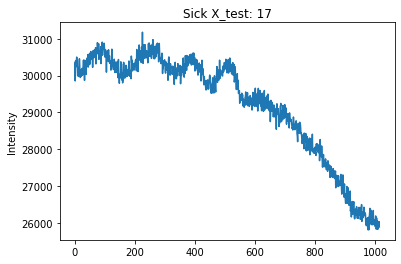

TrueLabel: Sick, PredLabel Health; PredProb: [0.59 0.41], TrueProb [0 1]


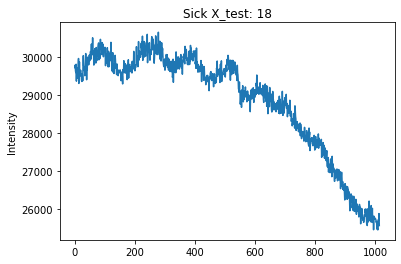

TrueLabel: Sick, PredLabel Health; PredProb: [0.53 0.47], TrueProb [0 1]


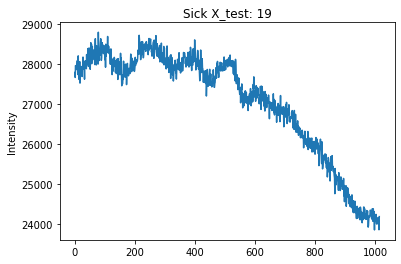

In [ ]:
pred = model.predict(X_test)
for i in range(5,20):
    sick_true = "Sick" if (y_test[i] == [0, 1]).all() else "Health"
    sick_pred = "Sick" if pred[i].argmax() else "Health"
    print(f'TrueLabel: {sick_true}, PredLabel {sick_pred}; PredProb: {np.round(pred,2)[i]}, TrueProb {y_test[i]}')
    plt.plot(X_test[i])
    plt.title(f"{sick_true} X_test: {i}")
    plt.ylabel("Intensity")

    plt.show()

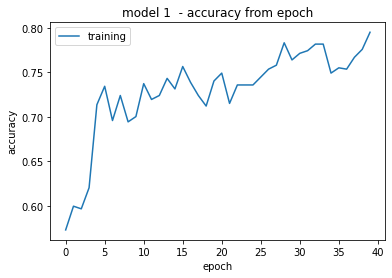

In [ ]:
loss, accuracy, f1  = model.evaluate(X_test, y_test, verbose=False)

plt.plot(model_hist.history['accuracy'])
plt.title('model 1  - accuracy from epoch')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='best')
plt.show()

CatBoost - градиентный бустинг от Яндекса, подбирает гиперпараметры модели самостоятельно, т.е. можно получить хороший результат без предварительной настройки

In [ ]:
from catboost import CatBoostClassifier
from sklearn.metrics import f1_score
model_catboost = CatBoostClassifier(verbose=False)
model_catboost.fit(X_train, y_train_labels)
print(f'CatBoost F1 Score {f1_score(y_test_labels, model_catboost.predict(X_test))}')

from sklearn.metrics import accuracy_score
print(f'CatBoost Accuracy {accuracy_score(y_test_labels, model_catboost.predict(X_test))}')

CatBoost F1 Score 0.920353982300885
CatBoost Accuracy 0.9158878504672897


TrueLabel: Health, PredLabel Health; PredProb: [0.99 0.01], TrueProb [1 0]


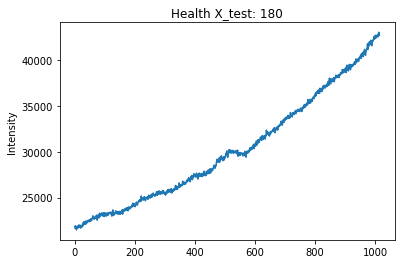

TrueLabel: Sick, PredLabel Sick; PredProb: [0.14 0.86], TrueProb [0 1]


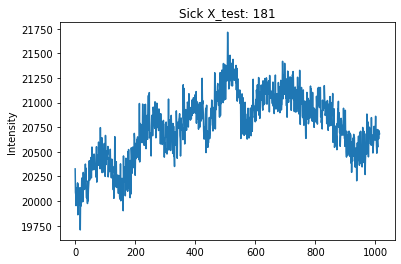

TrueLabel: Sick, PredLabel Sick; PredProb: [0.01 0.99], TrueProb [0 1]


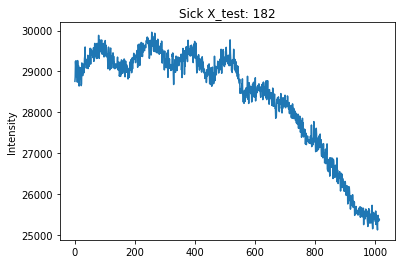

TrueLabel: Health, PredLabel Health; PredProb: [1. 0.], TrueProb [1 0]


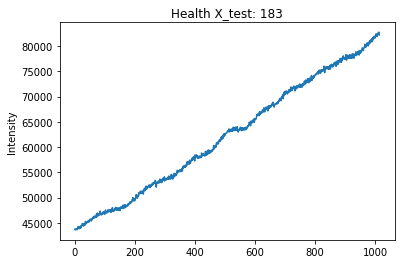

TrueLabel: Health, PredLabel Health; PredProb: [1. 0.], TrueProb [1 0]


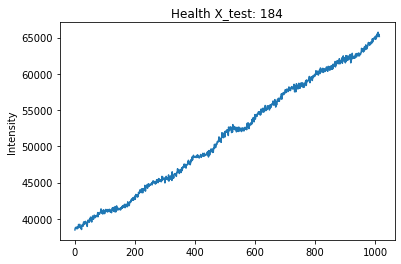

TrueLabel: Health, PredLabel Health; PredProb: [0.99 0.01], TrueProb [1 0]


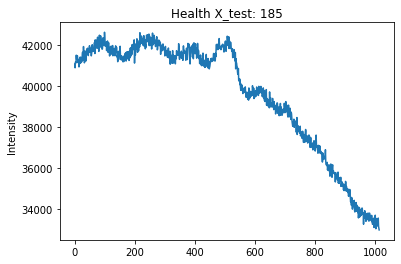

TrueLabel: Health, PredLabel Health; PredProb: [0.91 0.09], TrueProb [1 0]


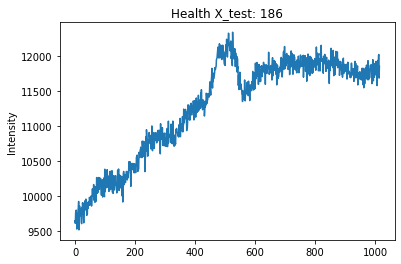

TrueLabel: Health, PredLabel Health; PredProb: [0.99 0.01], TrueProb [1 0]


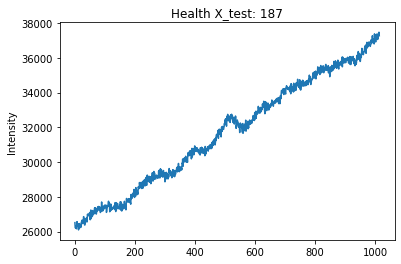

TrueLabel: Health, PredLabel Health; PredProb: [1. 0.], TrueProb [1 0]


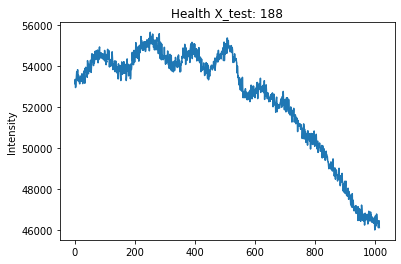

In [ ]:
pred = model_catboost.predict_proba(X_test)
for i in range(180,189):
    sick_true = "Sick" if (y_test[i] == [0, 1]).all() else "Health"
    sick_pred = "Sick" if pred[i].argmax() else "Health"
    print(f'TrueLabel: {sick_true}, PredLabel {sick_pred}; PredProb: {np.round(pred,2)[i]}, TrueProb {y_test[i]}')
    plt.plot(X_test[i])
    plt.title(f"{sick_true} X_test: {i}")
    plt.ylabel("Intensity")

    plt.show()

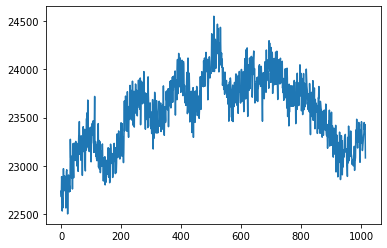

In [ ]:
plt.plot(X_train[20])
plt.show()

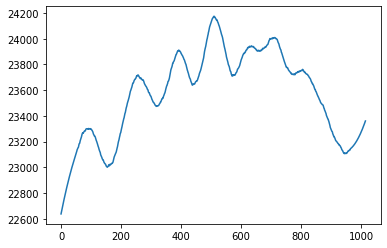

In [ ]:
from scipy.signal import savgol_filter
w = savgol_filter(X_train[20], 101, 2)
plt.plot(w)  # high frequency noise removed
plt.show()

Savitzky-Golay filter (Фильтр Савицки-Голея) - фильтр для сглаживания данных. Параметр window_length - нечетное число, чем больше чем сглаженне данные

Аналоги которые можно попробовать: Kalman filter, IIR filter, LOWESS 

*   Kalman filter
*   IIR filter
*   LOWESS (Locally Weighted Scatterplot Smoothing)
*   rolling mean
*   RBF (radial basis function) interpolation

In [ ]:
from scipy.signal import savgol_filter
for i in range(len(X_train)):
    X_train[i] = savgol_filter(X_train[i], 101, 2)

In [ ]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:
# Model 2
model2 = Sequential()
model2.add(Conv1D(128, 4, activation='relu', input_shape=(1015,1),kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4))) # 32 neurons
model2.add(Conv1D(128, 4, activation='relu', bias_regularizer=regularizers.l2(1e-4))) # 32 neurons
model2.add(BatchNormalization())
model2.add(Activation('relu'))
model2.add(MaxPooling1D())
model2.add(Dropout(0.25))
model2.add(Conv1D(256, 2, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4))) # 64 neurons
model2.add(Conv1D(256, 2, activation='relu', bias_regularizer=regularizers.l2(1e-4))) # 64 neurons
model2.add(BatchNormalization())
model2.add(Activation('relu'))
model2.add(MaxPooling1D())
model2.add(Dropout(0.25))
model2.add(Flatten())
model2.add(Dense(256, activation = 'relu', use_bias=False))
model2.add(BatchNormalization())
model2.add(Activation('relu'))
model2.add(Dense(128, activation = 'relu', use_bias=False))
model2.add(BatchNormalization())
model2.add(Activation('relu'))
model2.add(Dense(64, activation = 'relu', use_bias=False))
model2.add(BatchNormalization())
model2.add(Activation('relu'))
model2.add(Dropout(0.25))
model2.add(Dense(2, activation = 'softmax'))
model2.summary()
model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', f1])
model2_hist = model2.fit(X_train, y_train, batch_size=128, epochs=100, verbose=1)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 1012, 128)         640       
                                                                 
 conv1d_5 (Conv1D)           (None, 1009, 128)         65664     
                                                                 
 batch_normalization_5 (Batc  (None, 1009, 128)        512       
 hNormalization)                                                 
                                                                 
 activation_5 (Activation)   (None, 1009, 128)         0         
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 504, 128)         0         
 1D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 504, 128)         

In [ ]:
acc = model2.evaluate(X_test, y_test)
print("Loss:", acc[0], " Accuracy:", acc[1], " F1 :", acc[2])
pred = model2.predict(X_test)
print(np.round(pred,2)[0], np.round(pred,2)[1])
print(X_test[22])
#model2.save("model2.h5")

7/7 [==============================] - 0s 13ms/step - loss: 0.6731 - accuracy: 0.6636 - f1: 0.6725
Loss: 0.6731101870536804  Accuracy: 0.663551390171051  F1 : 0.6724837422370911
7/7 [==============================] - 0s 10ms/step
[0.97 0.03] [0.45 0.55]
[21382.988281 21374.837891 21435.46875  ... 39662.578125 39570.792969
 39699.359375]


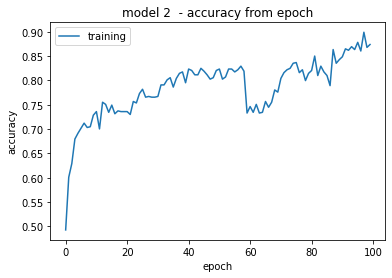

In [ ]:
loss, accuracy, f1  = model2.evaluate(X_test, y_test, verbose=False)

plt.plot(model2_hist.history['accuracy'])
plt.title('model 2  - accuracy from epoch')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='best')
plt.show()

In [ ]:
from catboost import CatBoostClassifier
from sklearn.metrics import f1_score, accuracy_score
model_catboost = CatBoostClassifier(verbose=False)
model_catboost.fit(X_train, y_train_labels)
print(f'CatBoost F1 Score {f1_score(y_test_labels, model_catboost.predict(X_test))}')
print(f'CatBoost Accuracy {accuracy_score(y_test_labels, model_catboost.predict(X_test))}')

CatBoost F1 Score 0.9339207048458149
CatBoost Accuracy 0.9299065420560748


In [ ]:
!pip install tsmoothie

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
print(f'Total amount of train measurements: {X_train.shape}')
print(f'Total amount of train labels: {y_train.shape}')
print(f'Total amount of test measurements: {X_test.shape}')
print(f'Total amount of test labels: {y_test.shape}')
y_train_labels = np.argmax(y_train, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

Total amount of train measurements: (666, 1015)
Total amount of train labels: (666, 2)
Total amount of test measurements: (222, 1015)
Total amount of test labels: (222, 2)


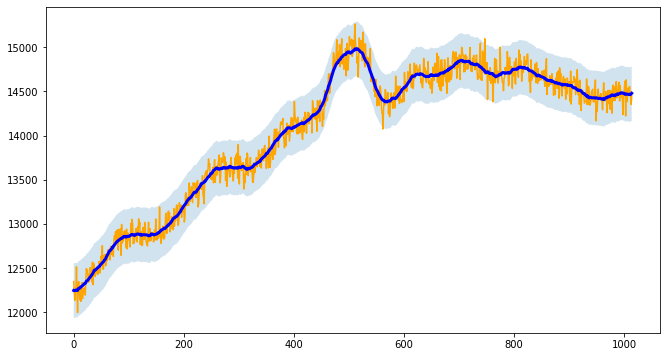

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tsmoothie.smoother import *

# operate smoothing
smoother = ConvolutionSmoother(window_len=30, window_type='ones')
smoother.smooth(X_train)

# generate intervals
low, up = smoother.get_intervals('sigma_interval', n_sigma=3)

plt.figure(figsize=(11,6))
plt.plot(smoother.data[21], color='orange')
plt.plot(smoother.smooth_data[21], linewidth=3, color='blue')
plt.fill_between(range(len(smoother.data[21])), low[21], up[21], alpha=0.2)

In [ ]:
# operate smoothing
smoother = ConvolutionSmoother(window_len=30, window_type='ones')
smoother.smooth(X_train)
X_train = smoother.smooth_data

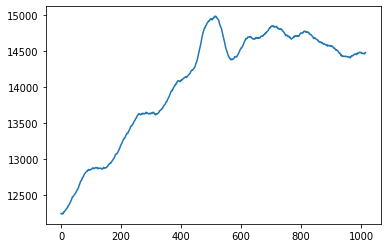

In [ ]:
plt.plot(X_train[21])

In [ ]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:
# Model 3
model3 = Sequential()
model3.add(Conv1D(128, 4, activation='relu', input_shape=(1015,1),kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4))) # 32 neurons
model3.add(Conv1D(128, 4, activation='relu', bias_regularizer=regularizers.l2(1e-4))) # 32 neurons
model3.add(BatchNormalization())
model3.add(Activation('relu'))
model3.add(MaxPooling1D())
model3.add(Dropout(0.25))
model3.add(Conv1D(256, 2, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4))) # 64 neurons
model3.add(Conv1D(256, 2, activation='relu', bias_regularizer=regularizers.l2(1e-4))) # 64 neurons
model3.add(BatchNormalization())
model3.add(Activation('relu'))
model3.add(MaxPooling1D())
model3.add(Dropout(0.25))
model3.add(Flatten())
model3.add(Dense(256, activation = 'relu', use_bias=False))
model3.add(BatchNormalization())
model3.add(Activation('relu'))
model3.add(Dense(128, activation = 'relu', use_bias=False))
model3.add(BatchNormalization())
model3.add(Activation('relu'))
model3.add(Dense(64, activation = 'relu', use_bias=False))
model3.add(BatchNormalization())
model3.add(Activation('relu'))
model3.add(Dropout(0.25))
model3.add(Dense(2, activation = 'softmax'))
model3.summary()
model3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', f1])
model3_hist = model3.fit(X_train, y_train, batch_size=128, epochs=100, verbose=1)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_8 (Conv1D)           (None, 1012, 128)         640       
                                                                 
 conv1d_9 (Conv1D)           (None, 1009, 128)         65664     
                                                                 
 batch_normalization_10 (Bat  (None, 1009, 128)        512       
 chNormalization)                                                
                                                                 
 activation_10 (Activation)  (None, 1009, 128)         0         
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 504, 128)         0         
 1D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 504, 128)         

In [ ]:
acc = model3.evaluate(X_test, y_test)
print("Loss:", acc[0], " Accuracy:", acc[1], " F1 :", acc[2])
pred = model3.predict(X_test)
print(np.round(pred,2)[0], np.round(pred,2)[1])
print(X_test[22])
#model3.save("model3.h5")

7/7 [==============================] - 0s 27ms/step - loss: 0.6564 - accuracy: 0.7072 - f1: 0.7065
Loss: 0.6563830971717834  Accuracy: 0.707207202911377  F1 : 0.7065475583076477
7/7 [==============================] - 0s 8ms/step
[1. 0.] [0.55 0.45]
[21382.988281 21374.837891 21435.46875  ... 39662.578125 39570.792969
 39699.359375]


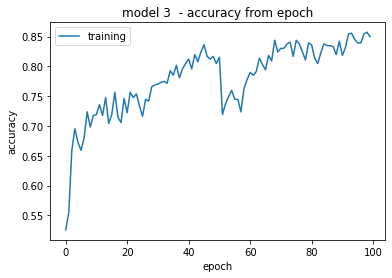

In [ ]:
loss, accuracy, f1  = model3.evaluate(X_test, y_test, verbose=False)

plt.plot(model3_hist.history['accuracy'])
plt.title('model 3  - accuracy from epoch')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='best')
plt.show()

In [ ]:
from catboost import CatBoostClassifier
model_catboost3 = CatBoostClassifier(verbose=False)
model_catboost3.fit(X_train, y_train_labels)
print(f'CatBoost F1 Score {f1_score(y_test_labels, model_catboost3.predict(X_test))}')
print(f'CatBoost Accuracy {accuracy_score(y_test_labels, model_catboost3.predict(X_test))}')

CatBoost F1 Score 0.9170305676855895
CatBoost Accuracy 0.9144144144144144


---
Вывод #2:

---
Neural Network Train: loss: 0.2720 - accuracy: 0.8754 - f1: 0.8715

CatBoost: Accuracy 0.925 F1 Score 0.93

---
After noise removed Savitzky-Golay filter:

---
Neural Network Train: loss: 0.2534 - accuracy: 0.8724 - f1: 0.8689

CatBoost: Accuracy 0.92 F1 Score 0.91

---
After noise removed ConvolutionSmoother:

---
Neural Network Train: loss: loss: 0.2582 - accuracy: 0.8754 - f1: 0.8868

CatBoost: Accuracy 0.92 F1 Score 0.91

---
Сглаживание не дало большого результата

---
Вывод #3:

CatBoost меньше ошибается на тестовых данных, дает более уверенные предсказания в отличии от нейросети
